In [1]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 54.0 MB/s eta 0:00:00


In [68]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import librosa

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd ..
%cd content
%cd gdrive
%cd MyDrive
%cd speech_recognition

/
/content
/content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive/speech_recognition


In [5]:
YES_FILE = os.path.join('yes', '00f0204f_nohash_0.wav')
NO_FILE = os.path.join('no', '0a9f9af7_nohash_0.wav')

In [6]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
yes_wave = load_wav_16k_mono(YES_FILE)
no_wave = load_wav_16k_mono(NO_FILE)

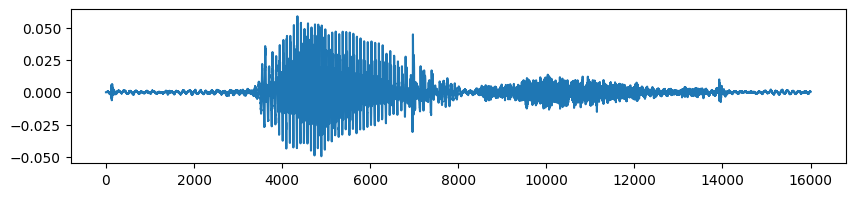

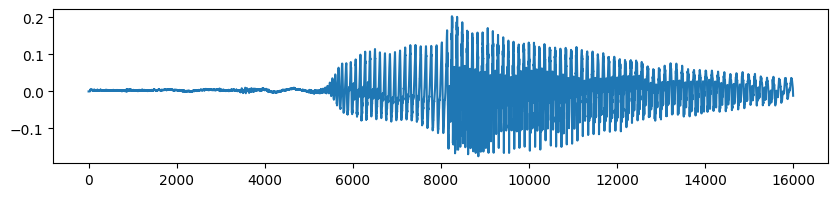

In [70]:
plt.figure(figsize=(10,2))
plt.plot(yes_wave)
plt.show()
plt.figure(figsize=(10,2))
plt.plot(no_wave)
plt.show()

In [9]:
# Create Tensorflow Datasets of paths
tf_yes = tf.data.Dataset.list_files(os.path.join('yes', '*.wav'))
tf_no = tf.data.Dataset.list_files(os.path.join('no', '*.wav'))

In [10]:
# Add labels and Combine 'yes' and 'no' Samples
yes = tf.data.Dataset.zip((tf_yes, tf.data.Dataset.from_tensor_slices(tf.ones(len(tf_yes)))))
no = tf.data.Dataset.zip((tf_no, tf.data.Dataset.from_tensor_slices(tf.zeros(len(tf_no)))))
data = yes.concatenate(no)

In [11]:
type(data)

tensorflow.python.data.ops.concatenate_op._ConcatenateDataset

In [12]:
yes.as_numpy_iterator().next(), no.as_numpy_iterator().next()

((b'yes/81dc4a94_nohash_0.wav', 1.0), (b'no/a827e3a1_nohash_1.wav', 0.0))

In [13]:
data.shuffle(5000).as_numpy_iterator().next()

(b'yes/e63b69c5_nohash_0.wav', 1.0)

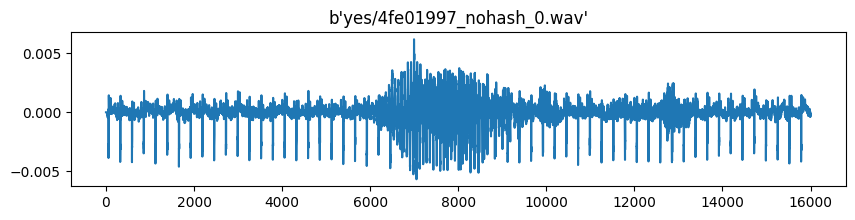

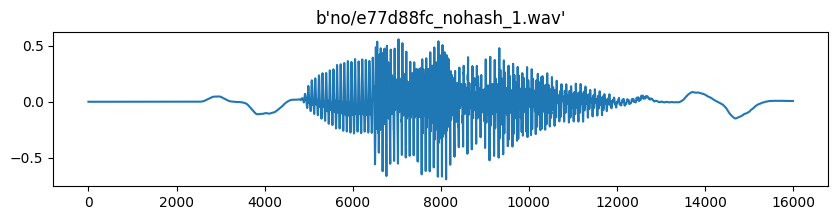

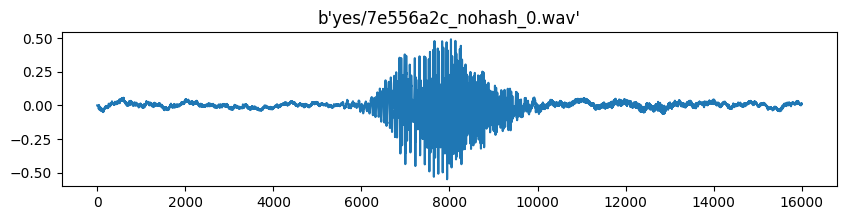

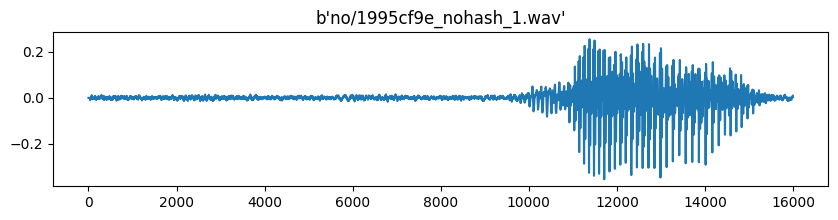

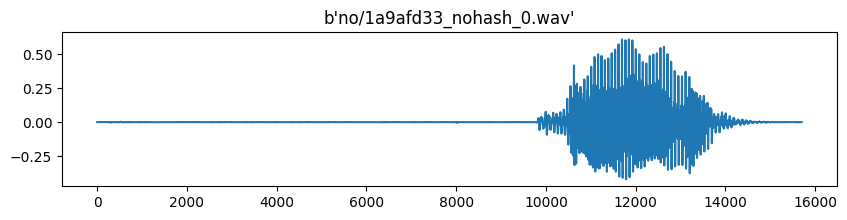

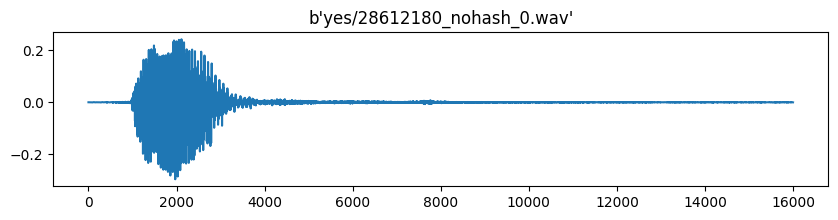

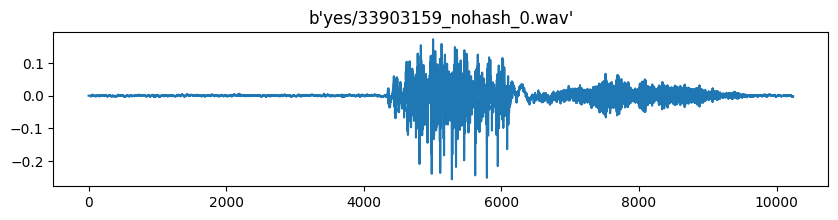

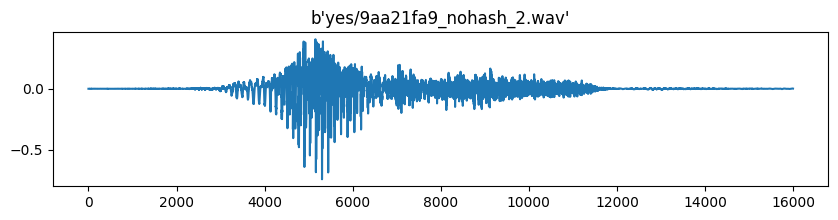

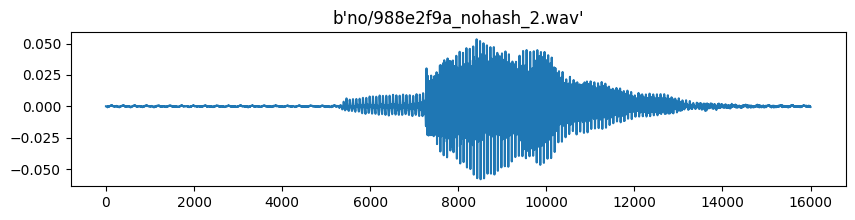

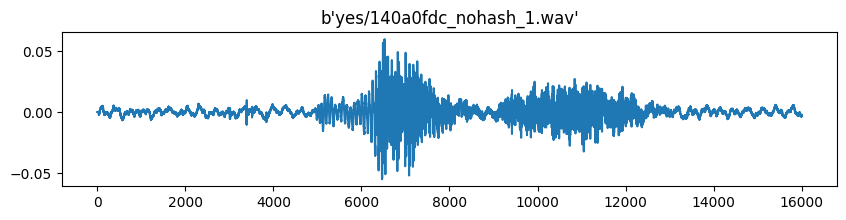

In [14]:
for ind in range(10):
  item = data.shuffle(5000).as_numpy_iterator().next()
  path = item[0]
  wave = load_wav_16k_mono(path)
  plt.figure(figsize=(10,2))
  plt.plot(wave)
  plt.title(path)
  plt.show()

In [72]:
lengths_yes = []
intensity_yes = []
for file in os.listdir(os.path.join('yes')):
    tensor_wave = load_wav_16k_mono(os.path.join('yes', file))
    lengths_yes.append(len(tensor_wave))

    intensity = tf.sqrt(tf.reduce_mean(tf.square(tensor_wave)))
    intensity_yes.append(intensity)

In [73]:
min(lengths_yes), max(lengths_yes), round(sum(lengths_yes)/len(lengths_yes), 1)

(8022, 16000, 15766.0)

In [81]:
# min(intensity_yes), max(intensity_yes), round(sum(intensity_yes)/len(intensity_yes), 1)
intensity_yes[0].shape


TensorShape([])

In [66]:
lengths_no = []
intensity_no = []
for file in os.listdir(os.path.join('no')):
    tensor_wave = load_wav_16k_mono(os.path.join('no', file))
    lengths_no.append(len(tensor_wave))

    intensity = tf.sqrt(tf.reduce_mean(tf.square(tensor_wave)))
    intensity_no.append(intensity)

In [67]:
min(lengths_no), max(lengths_no), round(sum(lengths_no)/len(lengths_no), 1)

(7431, 16000, 15709.0)

In [19]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [53]:
filepath, label = yes.shuffle(buffer_size=3000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
filepath

b'yes/72320401_nohash_1.wav'

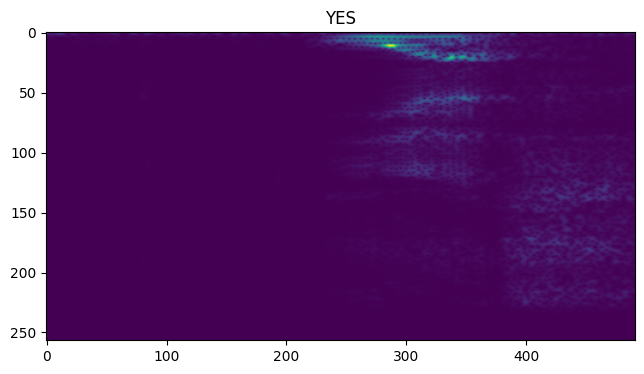

In [54]:
plt.figure(figsize=(20,4))
plt.imshow(tf.transpose(spectrogram)[0])
plt.title("YES")
plt.show()

In [55]:
filepath, label = no.shuffle(buffer_size=3000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
filepath

b'no/df038de4_nohash_0.wav'

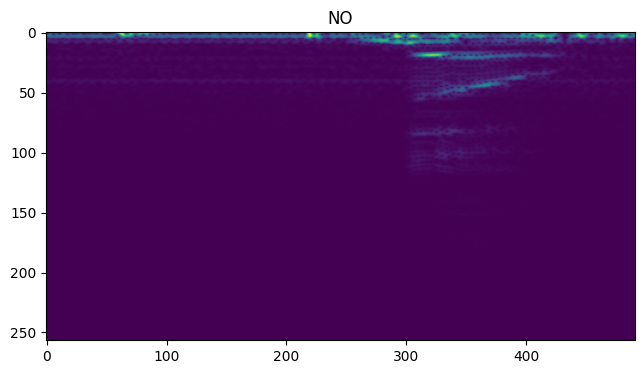

In [56]:
plt.figure(figsize=(20,4))
plt.imshow(tf.transpose(spectrogram)[0])
plt.title("NO")
plt.show()

In [24]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=5000)
data = data.batch(16)
data = data.prefetch(8)

In [25]:
len(data)

297

In [26]:
train = data.take(210)
test = data.skip(210).take(87)

In [27]:
samples, labels = train.as_numpy_iterator().next()

In [28]:
samples.shape, labels.shape

((16, 491, 257, 1), (16,))

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [30]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 489, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 487, 253, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 1971376)           0         
                                                                 
 dense (Dense)               (None, 128)               252336256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 252,338,865
Trainable params: 252,338,865
Non-trainable params: 0
_________________________________________________________________


In [33]:
hist = model.fit(train, epochs=2, validation_data=test)

Epoch 1/2
210/210 [==============================] - 1603s 8s/step - loss: 0.7252 - recall: 0.8688 - precision: 0.8945 - val_loss: 0.1571 - val_recall: 0.9339 - val_precision: 0.9789
Epoch 2/2
210/210 [==============================] - 1607s 8s/step - loss: 0.1278 - recall: 0.9423 - precision: 0.9784 - val_loss: 0.0609 - val_recall: 0.9797 - val_precision: 0.9839


In [34]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

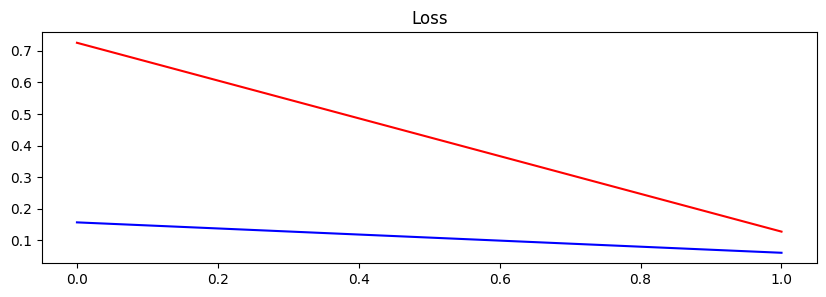

In [35]:
plt.figure(figsize=(10,3))
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

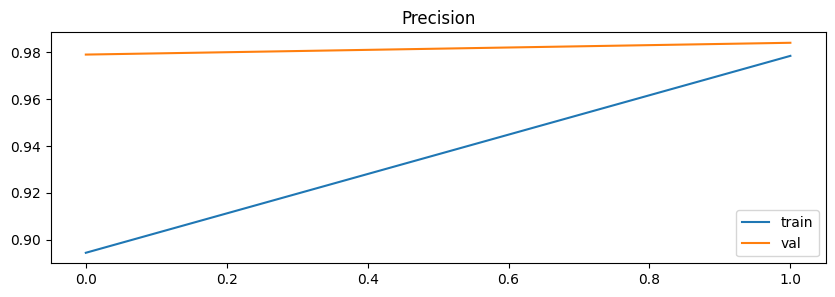

In [40]:
plt.figure(figsize=(10,3))
plt.title('Precision')
plt.plot(hist.history['precision'], label='train')
plt.plot(hist.history['val_precision'], label='val')
plt.legend()
plt.show()

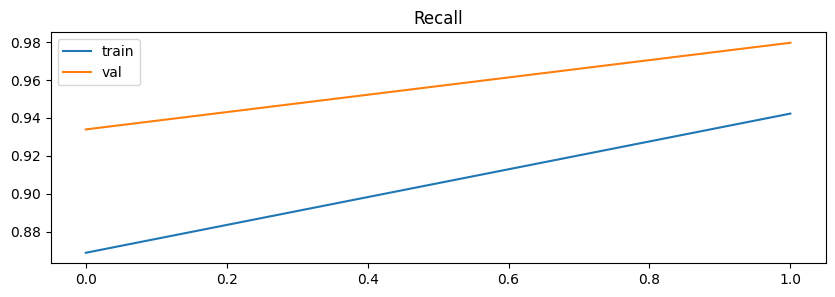

In [42]:
plt.figure(figsize=(10,3))
plt.title('Recall')
plt.plot(hist.history['recall'], label='train')
plt.plot(hist.history['val_recall'], label='val')
plt.legend()
plt.show()

In [38]:
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat, y_test

1/1 [==============================] - 1s 1s/step


([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0],
 array([0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.],
       dtype=float32))

In [43]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.0988 - recall: 1.0000 - precision: 1.0000


[0.09876099228858948, 1.0, 1.0]